In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(furrr)
library(cowplot)

devtools::load_all(".")

plan(multiprocess)

options(future.globals.maxSize = 1500*1024^2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/archaic-ychr
Loading required package: future

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading ychr


In [2]:
tmrca_df <- readRDS(here("data/rds/tmrca_df.rds"))

In [3]:
times_df <- filter(
    tmrca_df,
    afr == "a00", 
    (arch == "mez2" & capture == "full") | (arch == "elsidron2" & capture == "lippold"),
    sites == "all",
    dp == 3,
    filt == "filt50"
) %>%
group_by(arch) %>%
summarise(tmrca = mean(tmrca_new)) %>%
mutate(age = c(44000, 49000))

times_df

arch,tmrca,age
<chr>,<dbl>,<dbl>
elsidron2,366586.4,44000
mez2,377946.1,49000


In [4]:
#' Get positions at which individual 'ind' is different from
#' a set of individuals in 'group' (including hg19) and merge
#' those genotypes with 'test' individual at those positions
#' - this is the individual for whom we want to calculate TMRCA
#' with ind.
get_differences <- function(test, ind, polarize_by, gt, mindp) {
    capture <- ifelse(str_detect(test, "elsidron2"), "lippold", "full")

    ## load genotypes of the test individual
    test_gt <- here(paste0("data/vcf/", capture, "_", test, ".vcf.gz")) %>%
        read_vcf(mindp = mindp, maxdp = 0.98) %>%
        filter(!is.na(!!sym(test))) # keep only sites with data

    ## subset the panel to the individuals of interest
    gt <- gt[, c("chrom", "pos", "REF", "ALT", ind, polarize_by)]
    ## keep fixed differences between a group of individuals
    ## and sample 'ind' (implicitly includes hg19 to 'polarize_by')
    freq <- gt[, polarize_by] %>% rowMeans
    differences <- filter(gt, !!sym(ind) == 1, freq == 0)

    ## join genotypes of the test individual at informative sites
    joined_gt <- inner_join(differences, test_gt, by = c("chrom", "pos", "REF")) %>%
        filter(complete.cases(.)) %>%
        select(-ALT.y) %>%
        rename(ALT = ALT.x)

    joined_gt
}

In [5]:
estimate_split <- function(test, from, gt, ancestral_ind,  mindp) {
  derived <- get_differences(test, from, ancestral_ind, gt, mindp)

  counts <- ifelse(derived[[test]] == 0, "ref", "alt") %>%
    factor(levels = c("ref", "alt")) %>%
    table %>%
    as.matrix %>%
    t %>%
    as.data.frame

  times <- filter(times_df, arch == from)

  ## simulate confidence intervals by sampling REF/ALT counts from Poisson
  sample_refs <- rpois(1000, counts$ref)
  sample_alts <- rpois(1000, counts$alt)
  tmrca_ci <- quantile(
    sample_refs / (sample_refs + sample_alts) * (times$tmrca - times$age) + times$age,
    c(0.025, 0.975),
    na.rm = T
  )

  counts %>%
    mutate(
      from = from,
      test = test,
      prop_ref = ref / (ref + alt),
      tmrca = prop_ref * (times$tmrca - times$age) + times$age,
      tmrca_low = tmrca_ci[1],
      tmrca_high = tmrca_ci[2],
      dp = mindp
    ) %>%
    select(from, test, everything())
}

## Neandertal lineage defined by _Mezmaiskaya 2_

In [6]:
all_mez2 %<-%   read_genotypes("mez2", "full", mindp = 3, maxdp = 0.98, nodmg = F, var_only = T)
nodmg_mez2 %<-% read_genotypes("mez2", "full", mindp = 3, maxdp = 0.98, nodmg = T, var_only = T)

In [7]:
targets <- c("spy1", "elsidron2", "shotgun_spy1", "spy1_merged", "shotgun_mez2", paste0("elsidron2_dp", 1:7))
ancestral_ind <- c("a00", "chimp", "S_French_1")

All SNPs:

In [8]:
tmrca_mez2_all <- map_dfr(1:5, function(dp) {
    future_map_dfr(targets, ~ estimate_split(.x, "mez2", all_mez2, ancestral_ind, mindp = dp))
}) %>% mutate(sites = "all")

Non C-T/G-A SNPs:

In [9]:
tmrca_mez2_nodmg <- map_dfr(1:5, function(dp) {
    future_map_dfr(targets, ~ estimate_split(.x, "mez2", nodmg_mez2, ancestral_ind, mindp = dp))
}) %>% mutate(sites = "nodmg")

In [10]:
tmrca_mez2 <- bind_rows(tmrca_mez2_all, tmrca_mez2_nodmg)

In [11]:
saveRDS(tmrca_mez2, here("data/rds/tmrca_mez2.rds"))

In [12]:
tmrca_mez2 <- tmrca_mez2 %>%
    mutate(test = fix_name(test) %>%
           str_replace("^Spy 94a$", "Spy 94a (capture)") %>%
           str_replace("elsidron2_dp(\\d)", "El Sidrón (\\1X)") %>%
           str_replace("560 kb", "full")) %>%
    mutate(sites = ifelse(sites == "all", "all sites", "no C-T/G-A"))

In [13]:
tmrca_mez2 %>%
filter(from == "mez2", !str_detect(test, "Mez|shotgun|capture|X|Sidr")) %>%
mutate(set = case_when(
    str_detect(test, "560 kb") ~ "El Sidrón 1253 (full)",
    str_detect(test, "elsidron2_dp") ~ "El Sidrón 1253 (downsampled)",
    TRUE ~ "Spy 94a"
)) %>%
select(-from, -set)

test,ref,alt,prop_ref,tmrca,tmrca_low,tmrca_high,dp,sites
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
Spy 94a (merged),71,469,0.1314815,92250.32,83814.88,102157.6,1,all sites
Spy 94a (merged),51,314,0.1397260,94962.33,83315.75,107309.6,2,all sites
Spy 94a (merged),20,141,0.1242236,89862.87,74453.89,108808.4,3,all sites
Spy 94a (merged),13,66,0.1645570,103130.37,77184.06,129130.5,4,all sites
Spy 94a (merged),7,37,0.1590909,101332.33,67250.74,141779.7,5,all sites
Spy 94a (merged),43,266,0.1391586,94775.67,82515.76,108105.1,1,no C-T/G-A
Spy 94a (merged),32,173,0.1560976,100347.68,83703.34,117665.3,2,no C-T/G-A
Spy 94a (merged),13,74,0.1494253,98152.86,75463.15,125756.6,3,no C-T/G-A
Spy 94a (merged),7,33,0.1750000,106565.56,69559.13,149511.3,4,no C-T/G-A


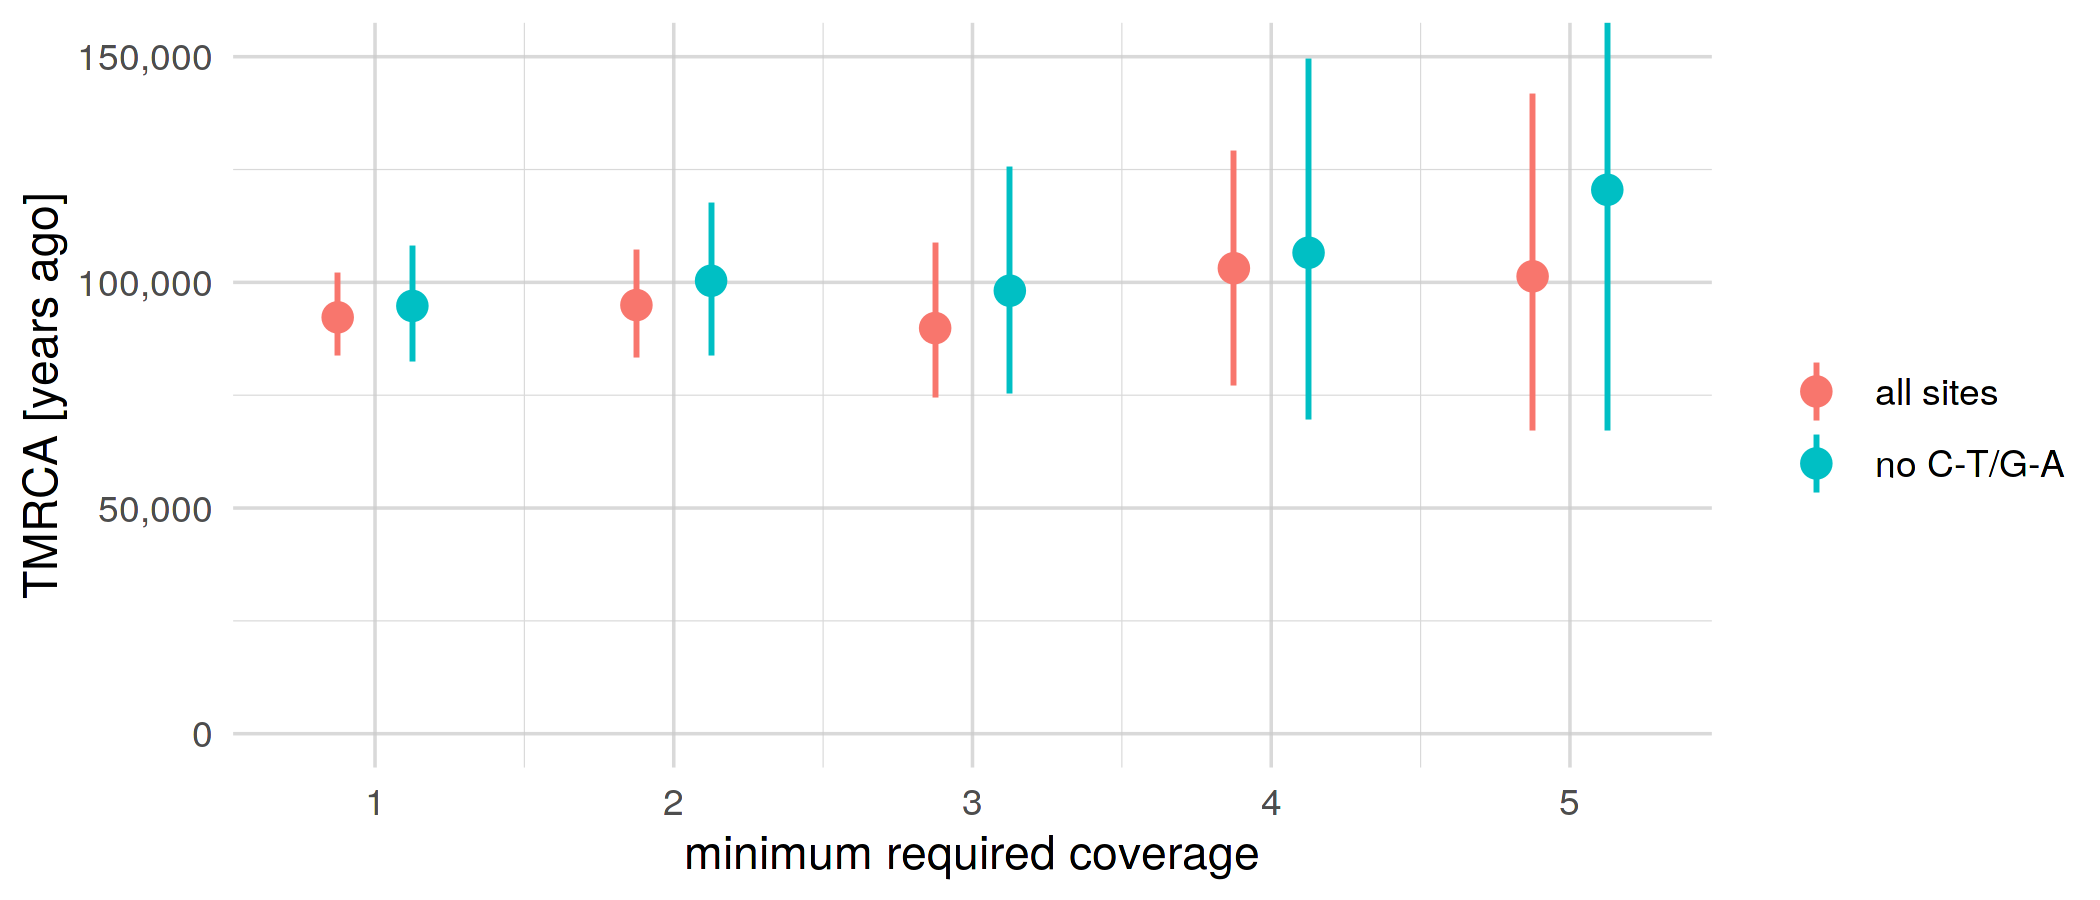

In [14]:
set_dim(7, 3)

tmrca_mez2 %>%
filter(from == "mez2", !str_detect(test, "Mez|shotgun|capture|X|Sidr")) %>%
mutate(set = case_when(
    str_detect(test, "560 kb") ~ "El Sidrón 1253 (full)",
    str_detect(test, "elsidron2_dp") ~ "El Sidrón 1253 (downsampled)",
    TRUE ~ "Spy 94a"
)) %>%
filter(!str_detect(test, "Mezmaiskaya")) %>%
ggplot(aes(test, tmrca)) +
    geom_pointrange(aes(dp, tmrca, ymin = tmrca_low, ymax = tmrca_high, color = sites),
                   position = position_dodge(0.5)) +
    coord_cartesian(ylim = c(0, 150000)) +
    theme_minimal() +
    background_grid(major = "xy", minor = "xy", size.major = 0.3, size.minor = 0.1,
                    color.major = rgb(0.8, 0.8, 0.8, alpha = 0.75)) +
    xlab("minimum required coverage") + ylab("TMRCA [years ago]") +
    scale_y_continuous(labels = scales::comma) +
    guides(color = guide_legend(title = ""))

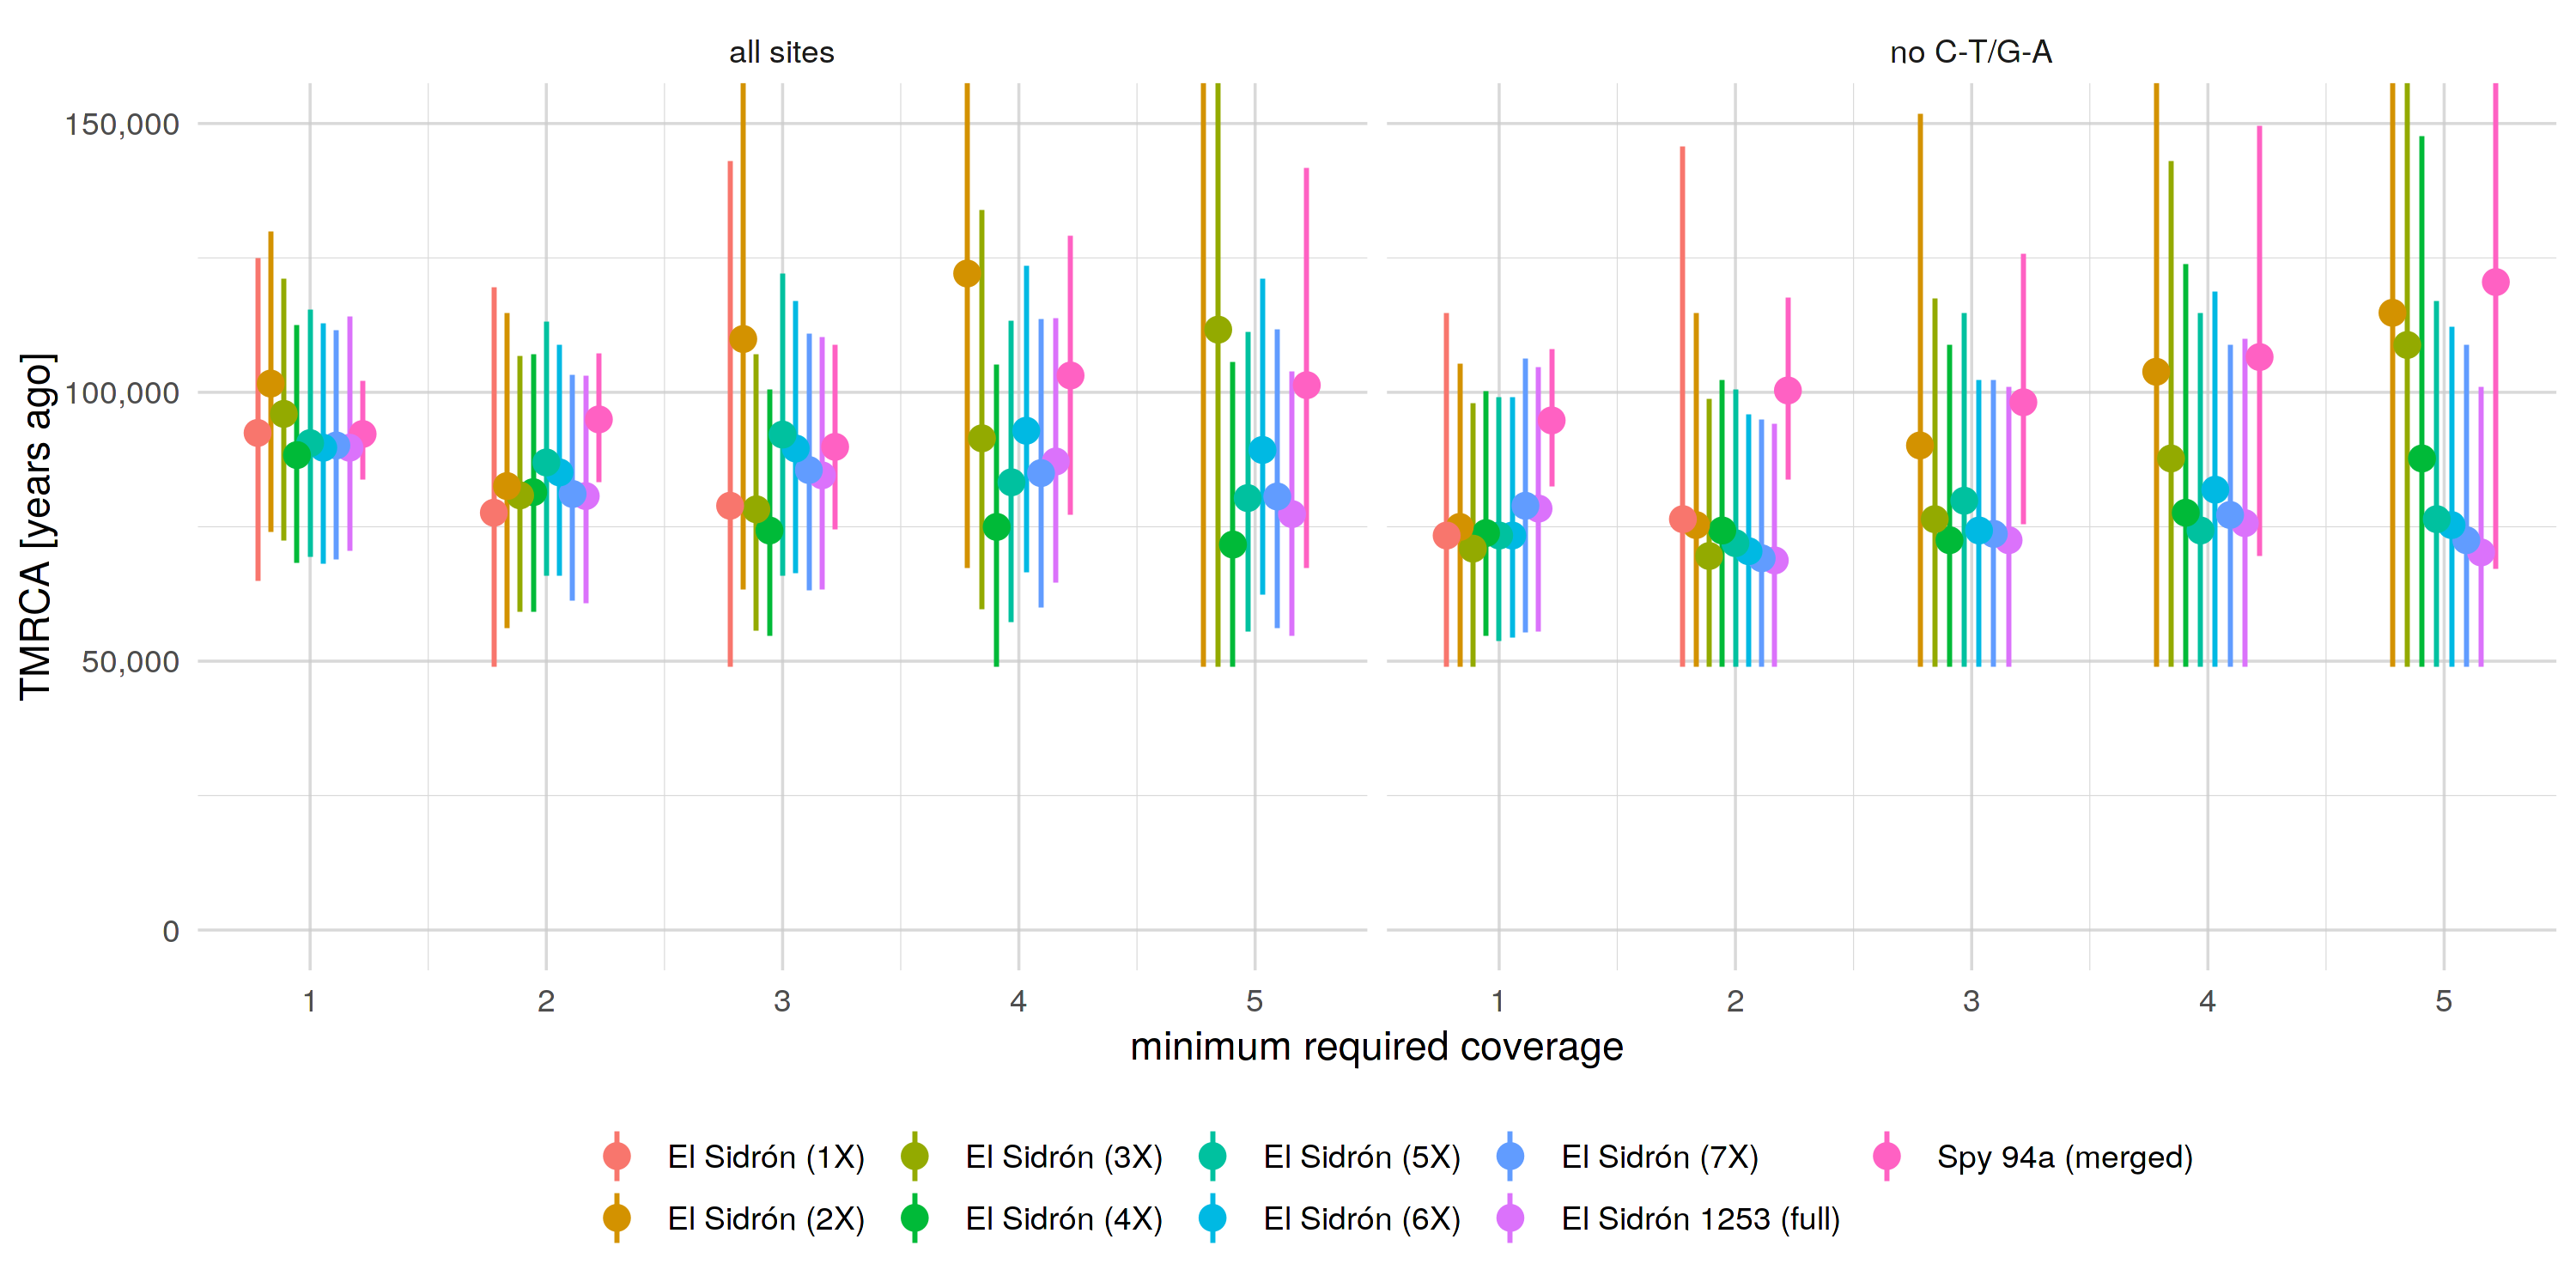

In [15]:
set_dim(10, 5)

tmrca_mez2 %>%
filter(ref > 0, alt > 0) %>% 
filter(from == "mez2", !str_detect(test, "Mez|shotgun|capture")) %>%
mutate(set = case_when(
    str_detect(test, "560 kb") ~ "El Sidrón 1253 (full)",
    str_detect(test, "elsidron2_dp") ~ "El Sidrón 1253 (downsampled)",
    TRUE ~ "Spy 94a"
)) %>%
filter(!str_detect(test, "Mezmaiskaya")) %>%
ggplot(aes(test, tmrca)) +
    geom_pointrange(aes(dp, tmrca, ymin = tmrca_low, ymax = tmrca_high, color = test),
                   position = position_dodge(0.5)) +
    coord_cartesian(ylim = c(0, 150000)) +
    theme_minimal() +
    theme(legend.position = "bottom") +
    facet_wrap(~ sites) +
    background_grid(major = "xy", minor = "xy", size.major = 0.3, size.minor = 0.1,
                    color.major = rgb(0.8, 0.8, 0.8, alpha = 0.75)) +
    xlab("minimum required coverage") + ylab("TMRCA [years ago]") +
    scale_y_continuous(labels = scales::comma) +
    guides(color = guide_legend(title = ""))